# Desafío - Inferencia de tópicos con EM

__Integrantes:__ 

- Yerko Carreño
- Javier Pilasi 
- Daniel Flores
- Francisco Fernandez
- Máximo Oliva
- Rocío Ehijo
- Cristián Contreras

**Descripción**
* En esta sesión trabajaremos con una serie de base de datos sobre letras musicales de distintos artistas. Cada uno de los csv se encuentra en la carpeta dump.
* Cada csv tiene el nombre del artista a analizar. Los archivos contienen el nombre del artista, el género musical del artista, el nombre de la canción y las letras.
* En base a esta información, el objetivo del ejercicio es generar un modelo probabilístico que pueda identificar el género musical más probable dado la letra de una canción. Para ello implementaremos un modelo conocido como Latent Dirichlet Allocation que hace uso de una variante del algoritmo EM para inferir clases latentes a partir de una matriz de documentos.

### Preparar el ambiente de trabajo
* Importe los módulos numpy , pandas , matplotlib , seaborn , glob y os siguiendo las buenas prácticas. Los últimos dos módulos permitirán realizar la importación de múltiples archivos dentro de la carpeta dump .
* Para ello genere un objeto que guarde en una lista todos los archivos alojados en dump utilizando glob.glob y os.getcwd() para extraer las rutas absolutas. Posteriormente genere un objeto pd.DataFrame que contenga todos los csv.
* Asegúrese de eliminar la columna Unnamed: 0 que se genera por defecto.

In [1]:
# Importar librerias
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import os
import warnings

from IPython.display import display, Markdown

warnings.filterwarnings('ignore')

In [22]:
# Leer archivos en ruta dump

files = glob.glob("dump/*", recursive=True)
li = []

for filename in files:
    df_file = pd.read_csv(filename, index_col=0)
    li.append(df_file)
    #display(os.getcwd())

df = pd.concat(li, ignore_index=True)
df.columns = ["artista", "genero", "cancion", "letra"]
display(df.head())
display(df.shape)

,artista,genero,cancion,letra
0,Vital Remains,metal,Human Sacrifice,Taken to death from sacrifice \n Carving out y...
1,Vital Remains,metal,Ressurrected,Doomed to an after life of pain \n Seeing your...
2,Vital Remains,metal,Fallen Angels,Fallen angels souls of hate \n Fallen angels c...
3,Vital Remains,metal,Excruciating Pain,Feel the torment of brutal bestial torture \n ...
4,Vital Remains,metal,Nocturnal Blasphemy,Blasphemy \n Awakened by nocturnal cries \n Su...


(9489, 4)

### Matriz de ocurrencias
* Importe la clase CountVectorizer dentro de los módulos feature_extraction.text de la librería sklearn .
* Aplique la clase para extraer las 5000 palabras más repetidas en toda la base de datos.
* Con la clase inicializada, incorpore las letras con el método fit_transform y guarde los resultados en un nuevo objeto

**Recordatorio**
* CountVectorizer utiliza el modelo de bag of words, donde a cada palabra se le asigna un único número. Entonces, cualquier documento, puede ser codificado como un vector de largo fijo con el largo del vocabulario de palabras conocidas. El valor en cada posición del vector puede ser llenado con la cuenta o frecuencia de cada palabra codificada.
* CountVectorizer permite tokenizar y vectorizar una colección de documentos de texto y construir un diccionario de palabras conocidas, también puede codificar nuevos documentos usando ese diccionario. Para usar CountVectorizar se debe:
    - Crear una instancia de de la clase CountVectorizer.
    - Llamar a la función fit() para que la función aprenda el vocabulario de uno o más documentos.
    - Llamar a la función transform() sobre uno o más documentos para codificarlo como vector.

In [3]:
from sklearn.feature_extraction.text import CountVectorizer

In [4]:
# Genera un dataframe a partir de un vector y su vocabulario
def vector_a_df(wm, feat_names):
    # create an index for each row
    doc_names = ['Cancion{:d}'.format(idx) for idx, _ in enumerate(wm)]
    df = pd.DataFrame(data=wm.toarray(), index=doc_names,
                      columns=feat_names)
    return(df)

In [5]:
# Instancia CountVectorizer
count_vectorizer=CountVectorizer(stop_words='english')
# Vector
vector=count_vectorizer.fit_transform(df['letra'])
# Palabras
palabras=count_vectorizer.get_feature_names()
# frecuencias
frec_palabras = vector.toarray().sum(axis=0)
# diccionario
data = {'palabra': palabras, 'frecuencia': frec_palabras}
# df
df_5000 = pd.DataFrame(data).sort_values('frecuencia', ascending=False).head(5000).reset_index(drop=True)
display(df_5000.head())
display(df_5000.shape)

,palabra,frecuencia
0,like,19629
1,don,17398
2,know,14962
3,got,14171
4,just,13978


(5000, 2)

### Entrenamiento del Modelo
* Importe sklearn.decomposition.LatentDirichletAllocation y sklearn.model_selection.GridSearchCV .
* Genere una búsqueda de grilla con los siguientes hiperparámetros:
    * n_components: [5, 10, 15] .
    * learning_decay: [0.7, 0.5] .
* Entrene la búsqueda de grilla con las letras en un formato vectorizado con CountVectorizer .
* Reporte brevemente cuál es la mejor combinación de hiperparámetros

> Digresión: Latent Dirichlet Allocation
> * Latent Dirichlet Allocatio (LDA) es un modelo probabilístico generativo basado en Inferencia Variacional EM. La principal utilidad de éste es la identificación de tópicos en un corpus de texto. 
> * El proceso de inferencia se puede resumir en los siguientes pasos:
>    * Cada documento dentro del corpus se puede entender como una mezcla de tópicos comunes a nivel de corpus.
>    * Esta mezcla de tópicos es latente $\leadsto$ Sólo observamos los documentos registrados y sus palabras. La API de sklearn.decomposition.LatentDirichletAllocation presenta la misma funcionalidad de todo modelo de sklearn. Algunos puntos a considerar en la inicialización de la clase son:
>        * n_components : Cantidad de tópicos a inferir en un corpus.
>        * learning_method : Forma en la que entran los datos en entrenamiento. Cuando es 'batch' , se ingresa la matriz de entrenamiento completa. Cuando es 'online' , la matriz de entrenamiento ingresa de manera secuencial en parcelas pequeñas.
>        * learning_decay : Tasa de aprendizaje en la función de pérdida. Cuando se implementa con learning_method='online', el modelo se entrena con Gradiente Estocástico Descendente.
>        * Perplejidad: Busca aproximar el número óptimo de tópicos a inferir. Técnicamente evalúa qué tan bien predice una muestra específica. En funcion a un número de tópicos, define la distribución teórica de palabras representada por los tópicos y la compara con la ocurrencia empírica de palabras en tópicos

In [6]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV

In [7]:
n_componentes =[5,10,15]
learning_decay =[0.7,0.5]

params=[{'n_components':n_componentes,
        'learning_decay':learning_decay,
        'learning_method':['batch','online']
        }]
lda_grid = GridSearchCV(LatentDirichletAllocation(),params,cv=10,n_jobs=-1)
lda_grid.fit(vector)

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=LatentDirichletAllocation(batch_size=128,
                                                 doc_topic_prior=None,
                                                 evaluate_every=-1,
                                                 learning_decay=0.7,
                                                 learning_method='batch',
                                                 learning_offset=10.0,
                                                 max_doc_update_iter=100,
                                                 max_iter=10,
                                                 mean_change_tol=0.001,
                                                 n_components=10, n_jobs=None,
                                                 perp_tol=0.1,
                                                 random_state=None,
                                                 topic_word_prior=None,
                                       

In [8]:
# mejores hiperparámetros
lda_grid.best_params_

{'learning_decay': 0.7, 'learning_method': 'online', 'n_components': 5}

In [9]:
df_results = pd.DataFrame(lda_grid.cv_results_)
df_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_decay,param_learning_method,param_n_components,params,split0_test_score,split1_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,163.026033,6.065870,1.567643,0.232852,0.7,batch,5,"{'learning_decay': 0.7, 'learning_method': 'ba...",-1.458950e+06,-1.504722e+06,...,-1.051789e+06,-1.466054e+06,-1.157441e+06,-1.097453e+06,-1.543623e+06,-1.700426e+06,-1.902001e+06,-1.391530e+06,280503.574858,3
1,182.759266,3.677920,1.946550,0.289532,0.7,batch,10,"{'learning_decay': 0.7, 'learning_method': 'ba...",-1.545658e+06,-1.595150e+06,...,-1.125931e+06,-1.562287e+06,-1.234195e+06,-1.196264e+06,-1.637466e+06,-1.798342e+06,-2.019788e+06,-1.482154e+06,291030.609725,10
2,171.632436,14.482200,1.820135,0.245006,0.7,batch,15,"{'learning_decay': 0.7, 'learning_method': 'ba...",-1.628031e+06,-1.665474e+06,...,-1.189735e+06,-1.644260e+06,-1.313649e+06,-1.275462e+06,-1.709076e+06,-1.870584e+06,-2.104900e+06,-1.556826e+06,295093.370142,12
3,88.519097,16.256003,0.891475,0.312265,0.7,online,5,"{'learning_decay': 0.7, 'learning_method': 'on...",-1.443028e+06,-1.498093e+06,...,-1.025144e+06,-1.451417e+06,-1.144224e+06,-1.099351e+06,-1.530186e+06,-1.686155e+06,-1.896806e+06,-1.378644e+06,283099.366013,1
4,100.668197,12.886257,0.969427,0.273345,0.7,online,10,"{'learning_decay': 0.7, 'learning_method': 'on...",-1.476904e+06,-1.546309e+06,...,-1.077812e+06,-1.503798e+06,-1.185731e+06,-1.128639e+06,-1.570598e+06,-1.717709e+06,-1.948175e+06,-1.420644e+06,284441.962087,5


La mejor combinación de hiperparámetros es con 5 componentes, con un learning method 'online' (la matriz de entrenamiento ingresa de manera secuencial en parcelas pequeñas, y el modelo se entrena con Gradiente Estocástico Descendente) y learnign decay=0.5.

### Ejercicio 4 : Inferencia e Identificación de Tópicos
* En base a la mejor combinación de hiperparámetros, entrene el modelo con la matriz de atributos de las letras.
* Para identificar de qué se trata cada tópico, necesitamos identificar las principales 15 palabras asociadas con éste. Puede implementar la siguiente línea de código para identificar las principales palabras en un tópico:

```python
# mediante .components_ podemos extraer una matriz que entrega las distribución de palabras por cada tópico.

for topic_id, topic_name in enumerate(fit_best_lda.components_):
    # para cada tópico
    print("tópico: {}".format(topic_id + 1))
    # mediante argsort logramos ordenar los elementos por magnitud
    # para los elementos más relevantes ordenados por argsort, buscamos su correlativo
    # en la matriz dispersa y devolvemos el nombre.
    # finalmente concatenamos las palabras
    print(" ".join([counter.get_feature_names()[i] for i in topic_name.argsort()[:-15 - 1: -1]]))
```

* Comente a qué tópicos está asociada cada clase inferida.

In [10]:
fit_best_lda = LatentDirichletAllocation(n_components=5, learning_decay=0.5, learning_method='online')
fit_best_lda.fit(vector);

In [12]:
# mediante .components_ podemos extraer una matriz que entrega las distribución de palabras por cada tópico.
for topic_id, topic_name in enumerate(fit_best_lda.components_):
    # para cada tópico
    print("tópico: {}".format(topic_id + 1))
    print('-----------')
    # mediante argsort logramos ordenar los elementos por magnitud
    # para los elementos más relevantes ordenados por argsort, buscamos su correlativo
    # en la matriz dispersa y devolvemos el nombre.
    # finalmente concatenamos las palabras (calculadas en primera parte)
    print(" ".join([palabras[i] for i in topic_name.argsort()[:-15 - 1: -1]]))
    print()

tópico: 1
-----------
yeah oh baby hey got come ooh ah wanna let know rock girl everybody gonna

tópico: 2
-----------
man got money home old said na little new black big time long white city

tópico: 3
-----------
god death life blood die soul dead eyes future war world song moment light hell

tópico: 4
-----------
love don know just ll ve like time way want say let feel make cause

tópico: 5
-----------
like shit yo got nigga fuck ain em don niggas cause know ya man la



In [11]:
df['genero'].value_counts()

rock      4140
hiphop    2535
metal     1582
pop       1232
Name: genero, dtype: int64

1. **Tópico 1**: rock
2. **Tópico 2**: hiphop
3. **Tópico 3**: metal
4. **Tópico 4**: pop
5. **Tópcio 5**: hiphop

### Ejercicio 5: Identificación de probabilidades
* En base a la información generada, es posible identificar cuales van a ser los géneros más probables de ocurrir para un artista.
* Para ello necesitamos guardar la probabilidad de cada canción en nuestra base de datos original. 
* Podemos implementar esto de la siguiente manera:
    
```python    
# generamos una transformación de los datos a distribución de tópico por palabra en el documento
fit_best_lda = best_lda.transform(transformed_feats)
# estra transformación la podemos coercionar a un dataframe de la siguiente manera
topics_for_each_doc = pd.DataFrame(
                                    # pasamos esta matriz y la redondeamos en 3 decimales
                                    np.round(fit_best_lda, 3),
                                    # agregamos un índice
                                    index=df_lyrics.index
                                    )
#agregamos identificadores de columna
topics_for_each_doc.columns = list(map(lambda x: "T: {}".format(x), range(1, best_lda.n_components + 1)))
# concatenamos las probabilidades de tópico por documento a nuestra matriz original
concatenated_df = pd.concat([df_lyrics, topics_for_each_doc], axis=1)
# argmax en la matriz de tópicos
concatenated_df['highest_topic'] = np.argmax(docs_topics.values, axis=1) + 1   

```

* Genere una matriz de correlaciones entre la probabilidad de tópicos inferidos. Comente brevemente cuales son las principales asociaciones existentes.

* Con esta nueva base de datos, identifique las probabilidades de pertenencia para un artista específico.

* Grafique la distribución de las probabilidades para algún artista en específico.

In [12]:
# generamos una transformación de los datos a distribución de tópico por palabra en el documento
# vector calculado en primera parte
fit_best_lda_trans = fit_best_lda.transform(vector)
# estra transformación la podemos coercionar a un dataframe de la siguiente manera
topics_for_each_doc = pd.DataFrame(
    # pasamos esta matriz y la redondeamos en 3 decimales
    np.round(fit_best_lda_trans, 3),
    # agregamos un índice
    index=df['letra'].index
)
# agregamos identificadores de columna
topics_for_each_doc.columns = list(
    map(lambda x: "T: {}".format(x), range(1, fit_best_lda.n_components + 1)))
# concatenamos las probabilidades de tópico por documento a nuestra matriz original
concatenated_df = pd.concat(
    [df['artista'], df['letra'], topics_for_each_doc], axis=1)
# argmax en la matriz de tópicos
concatenated_df['highest_topic'] = np.argmax(
    topics_for_each_doc.values, axis=1) + 1
concatenated_df.sample(10)

,artista,letra,T: 1,T: 2,T: 3,T: 4,T: 5,highest_topic
1696,Modest Mouse,"How do, how do you do? \n My name is you \n Th...",0.208,0.454,0.008,0.007,0.323,2
9266,A Tribe Called Quest,Now you caught my heart for the evening \n Kis...,0.416,0.175,0.033,0.119,0.256,1
2995,Bob Dylan,Melancholy mood forever haunts me \n Steals up...,0.003,0.254,0.300,0.022,0.421,5
3427,Oasis,Who will rise? \n It would be so nice to hear ...,0.106,0.229,0.002,0.002,0.660,5
4685,The Smashing Pumpkins,"Mother, I'm tired \n Come surrender my son \n ...",0.003,0.059,0.097,0.003,0.838,5
2479,System of a Down,Watching from a post up high \n From where you...,0.188,0.042,0.196,0.225,0.348,5
6953,MF Doom,I only play the games that I win at \n And sta...,0.432,0.073,0.063,0.285,0.146,1
7153,Kiss,My limousine is a-waitin' \n And I see you com...,0.531,0.177,0.001,0.001,0.289,1
8912,Eminem,"Hey Slim, \n U want a pill 2 pop \n Eh slim yo...",0.542,0.108,0.002,0.224,0.124,1
2535,System of a Down,So I felt like the biggest asshole \n (Felt li...,0.511,0.054,0.002,0.002,0.431,1


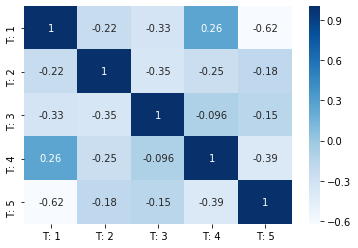

In [13]:
df_topics = concatenated_df.loc[:, 'T: 1':'T: 5']
sns.heatmap(df_topics.corr(), cmap='Blues', annot=True)

Las principales correlaciones (mayor o igual a 0.4) se dan entre:
* **T3 y T4**
* **T4 y T5**

In [19]:
# Se elige al grupo Metallica
# Se calcula el promedio de cada tópico de pertenencia asociado a las canciones del artista
df_metallica_T = concatenated_df[df['artista']
                                 == 'Metallica'].loc[:, 'T: 1':'T: 5']
means = []
for i, col in df_metallica_T.iteritems():
    mean = round(np.mean(col), 3)
    means.append(mean)
display(means)
data = {'topicos': df_metallica_T.columns, 'probabilidad': means}
df_metallica_prom = pd.DataFrame.from_dict(data)
df_metallica_prom

[0.08, 0.159, 0.294, 0.036, 0.431]

,topicos,probabilidad
0,T: 1,0.080
1,T: 2,0.159
2,T: 3,0.294
3,T: 4,0.036
4,T: 5,0.431


In [17]:
df_metallica_T.head()

,T: 1,T: 2,T: 3,T: 4,T: 5
45,0.432,0.105,0.068,0.022,0.373
46,0.002,0.128,0.295,0.034,0.541
47,0.003,0.046,0.003,0.003,0.945
48,0.248,0.113,0.371,0.002,0.266
49,0.400,0.067,0.400,0.067,0.067


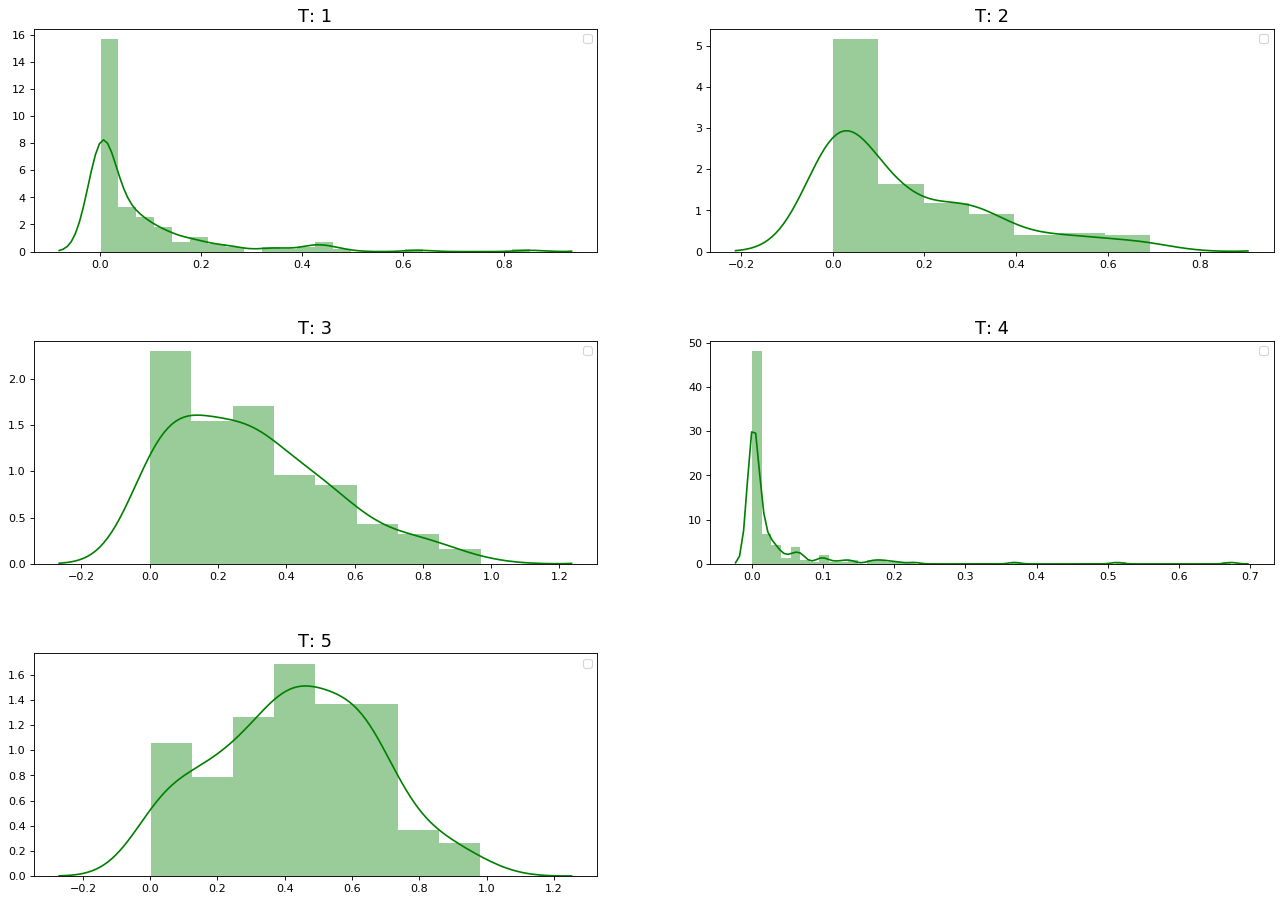

In [21]:
fig = plt.figure(figsize=(20, 800), dpi=80)
fig.subplots_adjust(hspace=0.4, wspace=0.2)
for index, variable in enumerate(df_metallica_T):
    ax = fig.add_subplot(len(df_metallica_T), 2, index + 1)
    sns.distplot(df_metallica_T[variable], axlabel=False, kde_kws={"label": variable}, color='green')
    ax.set_title('{}'.format(variable), size = 16)
    ax.legend([])